# Simple Neural Network using PyTorch


The following code contains multi-class classication of MNIST Handwritten Digits data using simple Multi-Layered Perceptron (MLP). The MLP has 784 inputs in the input layer and 10 outputs in the output layer.

In [1]:
#Importing all libraries
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torch.autograd import Variable

import time
import helper
from training import train, evaluate, epoch_time, count_parameters, calculate_accuracy
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

### Importing Dataset

In [2]:
#Import data
train_df = pd.read_csv("dataset/digit-recognizer/train.csv")
test_df = pd.read_csv("dataset/digit-recognizer/test.csv")

## Train and Validation datasets

In [3]:
#Labels(Targets) and Inputs
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,:].values).astype('float32')

#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, 
                                                                      train_labels,
                                                                     stratify=train_labels, 
                                                                      random_state=302,
                                                                     test_size=0.2)

## Reshaping the data to make Tensors

In [4]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)
#test
test_images_tensor = torch.tensor(test_images)/255.0

In [5]:
train_images_tensor.shape, train_labels_tensor.shape 

(torch.Size([33600, 784]), torch.Size([33600]))

## Viewing the Images

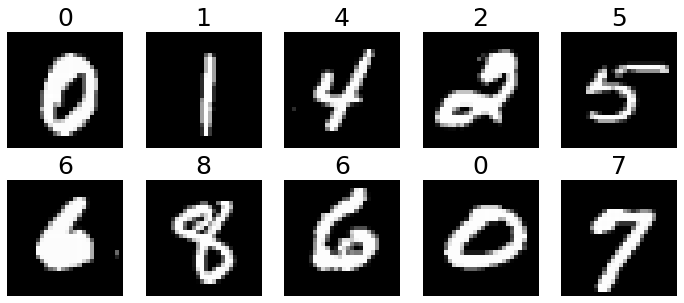

In [6]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,5000,size=10)
for i in range(10):
    axes[i].imshow(train_images[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(train_labels[idx[i]])), color= 'black', fontsize=25)
plt.show()

## Feeding them to data loader

In [7]:
#Dataloader
train_loader = DataLoader(train_tensor, batch_size = 64, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size = 64, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size = 32, num_workers=2, shuffle=False)

In [10]:
len(train_loader)

1050

## Defining Model Architecture

In [11]:
model = nn.Sequential(nn.Linear(784, 512),
                      nn.LeakyReLU(),
                      nn.Linear(512, 512),
                      nn.BatchNorm1d(512),
                      nn.LeakyReLU(),
                      nn.Linear(512, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=2.0e-4 , momentum = 0.09)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
device

device(type='cpu')

In [12]:
model

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=512, out_features=10, bias=True)
  (6): LogSoftmax(dim=1)
)

In [13]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 670,730 trainable parameters


## Training the model over train dataset

In [14]:
EPOCHS = 15
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 0.353 | Train Acc: 90.65%
	 Val. Loss: 0.180 |  Val. Acc: 94.75%
Epoch: 02 | Epoch Time: 0m 18s
	Train Loss: 0.152 | Train Acc: 95.67%
	 Val. Loss: 0.126 |  Val. Acc: 96.38%
Epoch: 03 | Epoch Time: 0m 18s
	Train Loss: 0.100 | Train Acc: 97.27%
	 Val. Loss: 0.106 |  Val. Acc: 96.78%
Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 0.072 | Train Acc: 98.06%
	 Val. Loss: 0.094 |  Val. Acc: 97.27%
Epoch: 05 | Epoch Time: 0m 18s
	Train Loss: 0.052 | Train Acc: 98.67%
	 Val. Loss: 0.083 |  Val. Acc: 97.31%
Epoch: 06 | Epoch Time: 0m 18s
	Train Loss: 0.041 | Train Acc: 98.97%
	 Val. Loss: 0.082 |  Val. Acc: 97.39%
Epoch: 07 | Epoch Time: 0m 18s
	Train Loss: 0.031 | Train Acc: 99.27%
	 Val. Loss: 0.081 |  Val. Acc: 97.61%
Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 0.024 | Train Acc: 99.47%
	 Val. Loss: 0.081 |  Val. Acc: 97.54%
Epoch: 09 | Epoch Time: 0m 18s
	Train Loss: 0.019 | Train Acc: 99.69%
	 Val. Loss: 0.081 |  Val. Acc: 97.59%
Epoch: 10 | Epoch T

In [33]:
"""
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
"""
print("")

## Loading the saved model

In [16]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Viewing the trained data images

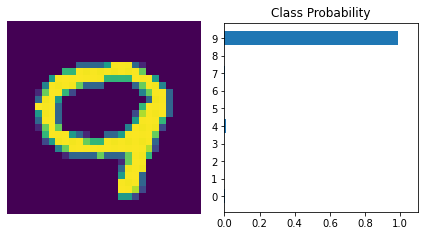

In [18]:
images, labels = next(iter(train_loader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps, version="MNIST")

## Prediction

In [28]:
def make_predictions(data_loader):
    model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        data = data.view(data.size(0), -1)
        output = model(data)
        
        preds = output.data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [30]:
test_set_preds = make_predictions(test_loader)
test_new = TensorDataset(test_images_tensor, test_set_preds)
testnew = DataLoader(test_new, batch_size=16, num_workers=2, shuffle=False)

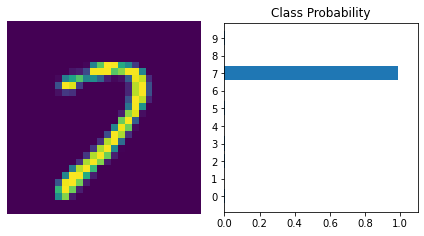

In [31]:
images, labels = next(iter(testnew))

idx = np.random.randint(0,16)
img = images[idx].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps, version="MNIST")

## Submission

In [19]:
sub = pd.read_csv("dataset/digit-recognizer/sample_submission.csv")
sub['Label'] = test_set_preds.numpy().squeeze()
sub.to_csv("MLP#1.csv", index=False)
#sub.head()